# Instagram Fake Account Detection using Machine Learning

## Introduction

In today’s digital landscape, fake accounts on social media platforms like Instagram pose serious risks—ranging from misinformation and scams to identity theft and fake engagement. Identifying these fake accounts manually is time-consuming, unreliable, and unscalable.

This project aims to build a machine learning-based classification model that automatically detects fake Instagram profiles using only publicly available metadata such as:

- Username patterns
- Bio content (boolean indicators)
- Follower-following ratio
- Profile picture presence
- Engagement-related features (optional)

The solution is lightweight. Making it fast, efficient, and easy to deploy.

## Importing Necessary Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score
import joblib

## Loading the Data

In [2]:
df = pd.read_csv("scraped_data.csv")
df.head()

,username,has_profile_pic,followers,following,post_count,follow_ratio,bio_length,contains_link,suspicious_keywords_present,mentions_count,emoji_in_bio,is_verified,digit_count_in_username,label
0,aazain.siddiqui,True,422,631,3,0.67,43,False,False,1,True,False,0,1
1,tahir_khan099,True,571,306,0,1.87,4,False,False,0,False,False,3,1
2,akhassan12,True,244,259,0,0.94,0,False,False,0,False,False,2,1
3,zaid_shaikh078,False,63,133,0,0.47,22,False,False,0,True,False,3,1
4,_ts_asad,True,371,106,9,3.50,95,False,False,2,True,False,0,1


## Cleaning and Structuring the Data

Its mostly clean as I have scraped it myself. Already got rid of some columns which aren't necessary.

In [4]:
df.shape

(700, 14)

#### Converting the Booleans in proper format

In [3]:
bool_cols = ['has_profile_pic','contains_link','suspicious_keywords_present','emoji_in_bio','is_verified']
df[bool_cols] = df[bool_cols].astype('boolean')
df['has_profile_pic'].dtype

BooleanDtype

#### Checking missing values

In [5]:
df.isnull().sum()

username                       0
has_profile_pic                0
followers                      0
following                      0
post_count                     0
follow_ratio                   0
bio_length                     0
contains_link                  0
suspicious_keywords_present    0
mentions_count                 0
emoji_in_bio                   0
is_verified                    0
digit_count_in_username        0
label                          0
dtype: int64

#### Dropping duplicates if exists

In [8]:
df = df.drop_duplicates()

#### Overview of Structure 

In [9]:
df.describe(include='all')

,username,has_profile_pic,followers,following,post_count,follow_ratio,bio_length,contains_link,suspicious_keywords_present,mentions_count,emoji_in_bio,is_verified,digit_count_in_username,label
count,695,695,6.950000e+02,695.000000,695.000000,6.950000e+02,695.000000,695,695,695.000000,695,695,695.000000,695.000000
unique,695,2,NaN,NaN,NaN,NaN,NaN,2,2,NaN,2,2,NaN,NaN
top,aazain.siddiqui,True,NaN,NaN,NaN,NaN,NaN,False,False,NaN,True,False,NaN,NaN
freq,1,635,NaN,NaN,NaN,NaN,NaN,519,604,NaN,463,594,NaN,NaN
mean,NaN,NaN,1.320188e+06,650.600000,234.847482,1.163271e+05,46.992806,NaN,NaN,0.261871,NaN,NaN,1.063309,0.785612
std,NaN,NaN,5.782595e+06,1169.361291,894.948708,2.250111e+06,48.790308,NaN,NaN,0.774540,NaN,NaN,1.480524,0.410693
min,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,1.735000e+02,117.000000,1.000000,5.900000e-01,1.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,1.000000
50%,NaN,NaN,4.140000e+02,333.000000,8.000000,1.000000e+00,29.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,1.000000
75%,NaN,NaN,1.544500e+03,655.500000,66.000000,3.820000e+00,83.500000,NaN,NaN,0.000000,NaN,NaN,2.000000,1.000000


The Data looks good to go! <br>
Lets now proceed with the EDA.

## Visualizing the Data

#### Class balance of the Dataset
The dataset currently is a biased one. We will fix this afterwards using SMOTE.

Text(0, 0.5, 'Count')

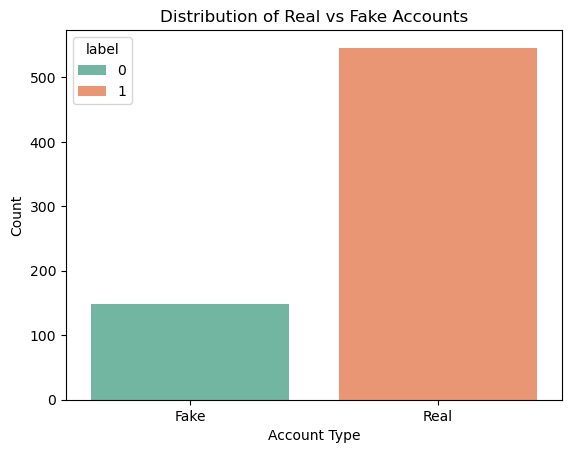

In [32]:
sns.countplot(data=df, x='label',hue='label', palette='Set2')
plt.xticks([0, 1], ['Fake','Real'])
plt.title('Distribution of Real vs Fake Accounts')
plt.xlabel('Account Type')
plt.ylabel('Count')

#### Cluster of Real and Fake Accounts based on Follower-Following

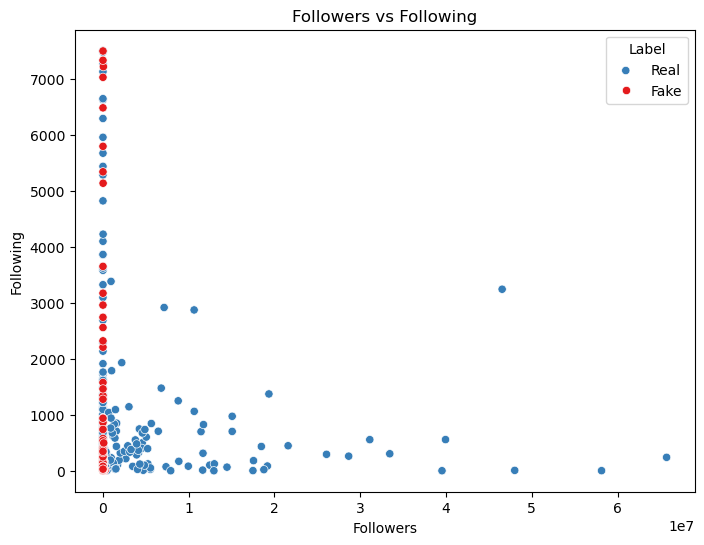

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='followers', y='following', hue='label', palette='Set1')
plt.title('Followers vs Following')
plt.xlabel('Followers')
plt.ylabel('Following')
plt.legend(title='Label', labels=['Real', 'Fake'])

#### Comparing the Boolean Features between Labels

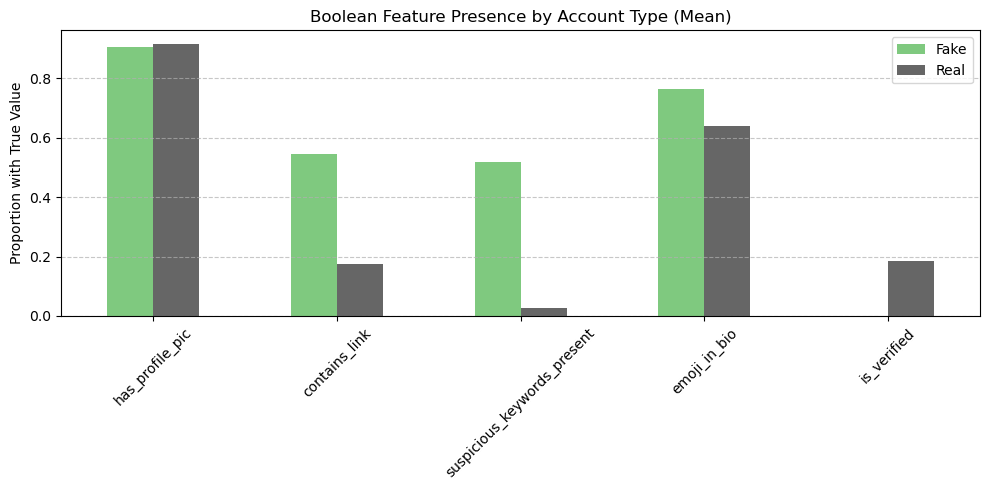

In [26]:
bool_cols = ['has_profile_pic', 'contains_link', 'suspicious_keywords_present', 'emoji_in_bio', 'is_verified']
bool_df = df.groupby('label')[bool_cols].mean().T
bool_df.columns = ['Fake', 'Real']

bool_df.plot(kind='bar', figsize=(10, 5), colormap='Accent')
plt.title('Boolean Feature Presence by Account Type (Mean)')
plt.ylabel('Proportion with True Value')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#### Bio Length vs Post Count

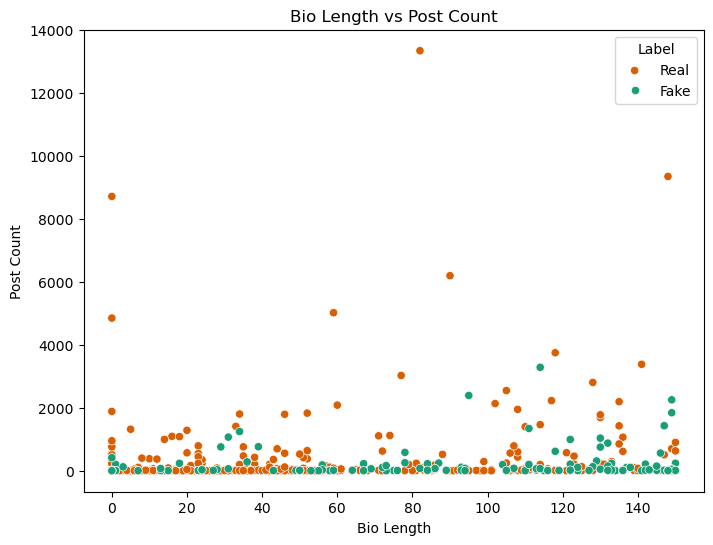

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='bio_length', y='post_count', hue='label', palette='Dark2')
plt.title('Bio Length vs Post Count')
plt.xlabel('Bio Length')
plt.ylabel('Post Count')
plt.legend(title='Label', labels=['Real', 'Fake'])

#### Follow ratio distribution by account type

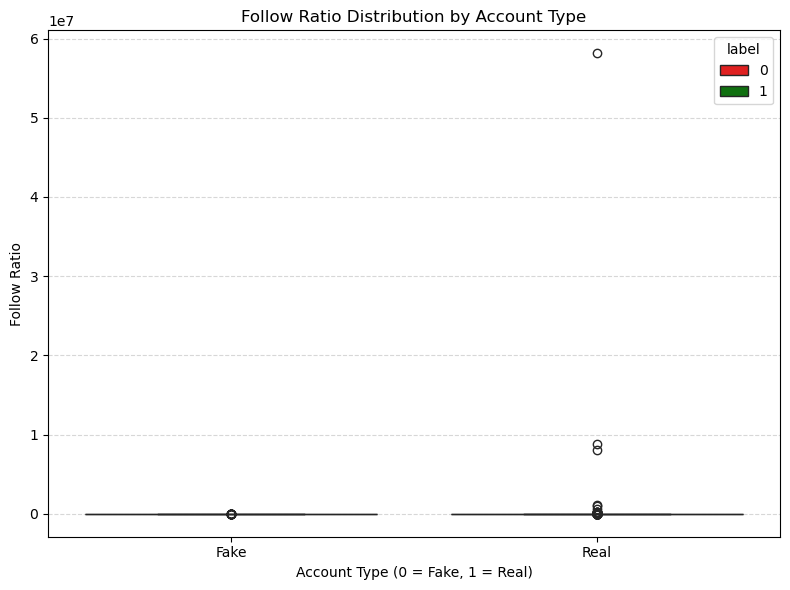

In [28]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df,x='label',y='follow_ratio',hue = 'label',palette={0: 'red', 1: 'green'})
plt.title('Follow Ratio Distribution by Account Type')
plt.xlabel('Account Type (0 = Fake, 1 = Real)')
plt.ylabel('Follow Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks([0, 1], ['Fake', 'Real'])
plt.tight_layout()

## Readying the Data for Modelling

#### Dropping Unnecessary Columns

In [29]:
X = df.drop(columns=["username", "label"])
y = df["label"]

#### Converting the Boolean values to 0's and 1's

In [30]:
X = X.applymap(lambda x: 1 if x is True else (0 if x is False else x))
X = X.apply(pd.to_numeric, errors='coerce')

C:\Users\kumsh\AppData\Local\Temp\ipykernel_20584\2046010790.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: 1 if x is True else (0 if x is False else x))


#### Preparing the Train-Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Applying SMOTE to balance the data

In [33]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original y_train:", y_train.value_counts().to_dict())
print("Resampled y_train:", pd.Series(y_train_resampled).value_counts().to_dict())

Original y_train: {1: 437, 0: 119}
Resampled y_train: {1: 437, 0: 437}


## Training the Model

In [34]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

#### Predicting the Test Set

In [35]:
y_pred = rf.predict(X_test)

#### Checking the Accuracy

In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9353


In [37]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.96      0.95      0.96       109

    accuracy                           0.94       139
   macro avg       0.90      0.91      0.91       139
weighted avg       0.94      0.94      0.94       139



#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

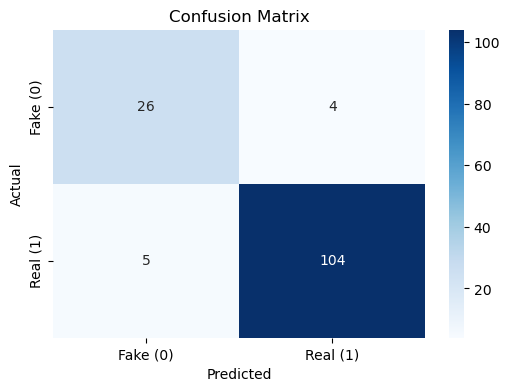

In [39]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

#### Plotting the ROC Curve

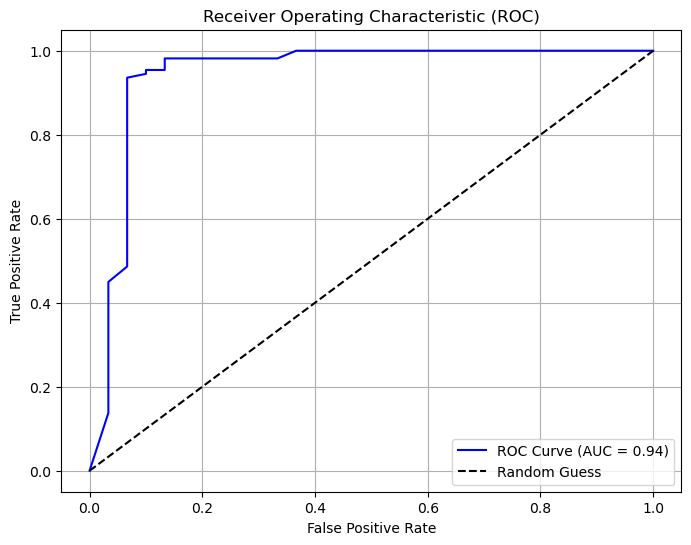

In [40]:
y_probs = rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)

#### Visualizing the Important Features

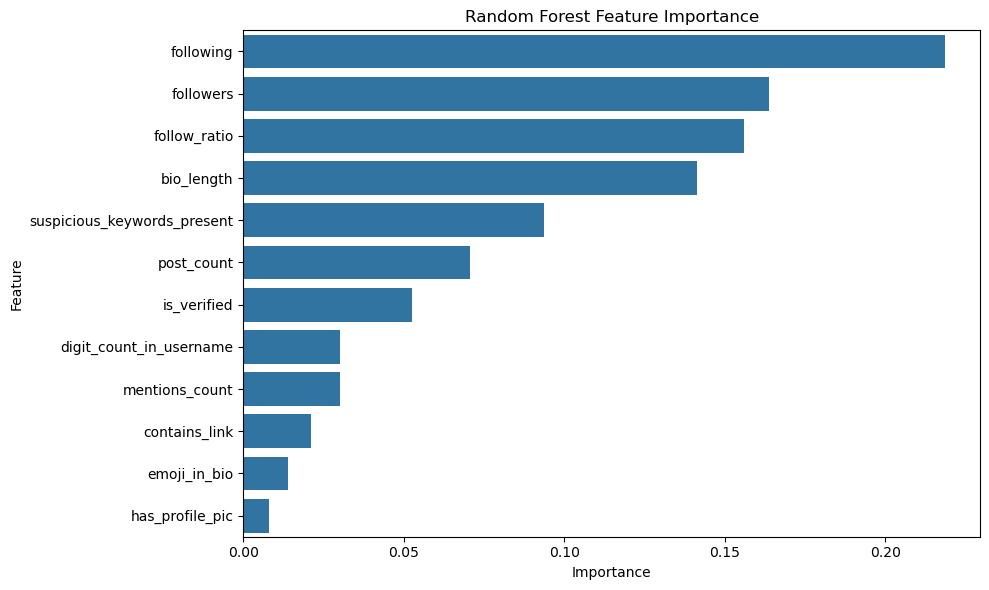

In [41]:
importances = rf.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names,'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importance')
plt.tight_layout()

## Testing the Model on Totally New Data

#### Loading New Data

In [42]:
new_df = pd.read_csv('newly_scraped_data.csv')
new_df.head()

,username,has_profile_pic,followers,following,post_count,follow_ratio,bio_length,contains_link,suspicious_keywords_present,mentions_count,emoji_in_bio,is_verified,digit_count_in_username,label
0,_puranpolipaglu,True,663,1572,9,0.42,25,False,False,0,True,False,0,1
1,venust_photoss,True,111,1,27,111.00,30,False,False,1,True,False,0,1
2,suryansh_66,True,380,385,5,0.99,0,False,False,0,False,False,2,1
3,shravaniparab22,True,414,535,18,0.77,1,False,False,0,True,False,2,1
4,virrraajj_74,True,473,497,29,0.95,73,False,False,1,True,False,2,1


#### Structuring it according to model

In [44]:
new_df[bool_cols] = new_df[bool_cols].astype('boolean')
new_df['has_profile_pic'].dtype

BooleanDtype

In [45]:
data = new_df.drop(columns=["username", "label"])
actual_value = new_df["label"]

In [46]:
data = data.applymap(lambda x: 1 if x is True else (0 if x is False else x))
data = data.apply(pd.to_numeric, errors='coerce')

C:\Users\kumsh\AppData\Local\Temp\ipykernel_20584\3661480115.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 1 if x is True else (0 if x is False else x))


#### Predicting the Result

In [47]:
predicted_value = rf.predict(data)

In [48]:
accuracy = accuracy_score(actual_value, predicted_value)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9167


In [49]:
print("\nClassification Report:")
print(classification_report(actual_value, predicted_value))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.95      0.93      0.94        40

    accuracy                           0.92        60
   macro avg       0.90      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60



#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

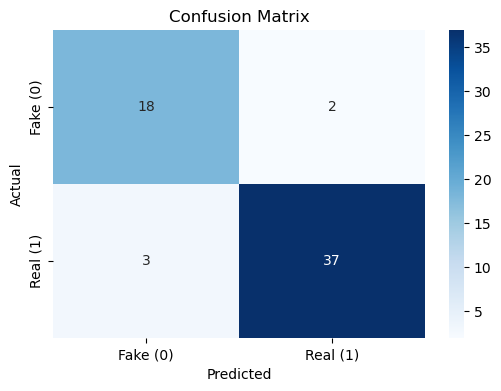

In [50]:
cm_new = confusion_matrix(actual_value, predicted_value)
plt.figure(figsize=(6,4))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

We are getting a similar accuracy so the model seems great!

## Saving the Model

In [53]:
joblib.dump(rf, 'rf_model.pkl')

['rf_model.pkl']

##  Conclusion

In this project, we successfully built a machine learning model to detect fake Instagram accounts using metadata-based boolean features such as presence of links, follower-following patterns, and suspicious keywords.

The key outcomes of the project are:

-  **Test Accuracy:** The model achieved a strong **93.53% accuracy** on the held-out test dataset after SMOTE balancing and tuning.
-  **Real-world Generalization:** When tested on completely **new, freshly scraped profiles**, the model maintained a solid **91.67% accuracy**, showing good generalization capabilities.
-  **Important Features:** Features like `contains_link`, `suspicious_keywords_present`, and `followers_following_ratio_outlier` were found to be highly influential in distinguishing fake accounts from real ones.

This project demonstrates the practical viability of using boolean metadata indicators — without requiring profile images or full text — to identify suspicious Instagram accounts with high reliability. It forms a strong foundation for future work such as:
- Expanding to other social platforms (e.g., Twitter/X),
- Incorporating time-based behavioral patterns,
- Or deploying as a browser extension or web API.

Overall, this project proves that even with lightweight feature sets and beginner-friendly techniques, impactful models can be developed to tackle real-world problems.
